# FDS Challenge: Starter Notebook

This notebook will guide you through the first steps of the competition. Our goal here is to show you how to:

1.  Load the `train.jsonl` and `test.jsonl` files from the competition data.
2.  Create a very simple set of features from the data.
3.  Train a basic model.
4.  Generate a `submission.csv` file in the correct format.
5.  Submit your results.

Let's get started!

## 1. Setup and Data Loading

In [1]:
import json
import pandas as pd
import os

# --- Define the path to our data ---
COMPETITION_NAME = 'fds-pokemon-battles-prediction-2025'
DATA_PATH = os.path.join('../input', COMPETITION_NAME)

train_file_path = os.path.join(DATA_PATH, 'train.jsonl')
test_file_path = os.path.join(DATA_PATH, 'test.jsonl')
train_data = []

# Read the file line by line
print(f"Loading data from '{train_file_path}'...")
try:
    with open(train_file_path, 'r') as f:
        for line in f:
            # json.loads() parses one line (one JSON object) into a Python dictionary
            train_data.append(json.loads(line))

    print(f"Successfully loaded {len(train_data)} battles.")

    # Let's inspect the first battle to see its structure
    print("\n--- Structure of the first train battle: ---")
    if train_data:
        first_battle = train_data[0]
        
        # To keep the output clean, we can create a copy and truncate the timeline
        battle_for_display = first_battle.copy()
        battle_for_display['battle_timeline'] = battle_for_display.get('battle_timeline', [])[:2] # Show first 2 turns
        
        # Use json.dumps for pretty-printing the dictionary
        print(json.dumps(battle_for_display, indent=4))
        if len(first_battle.get('battle_timeline', [])) > 3:
            print("    ...")
            print("    (battle_timeline has been truncated for display)")


except FileNotFoundError:
    print(f"ERROR: Could not find the training file at '{train_file_path}'.")
    print("Please make sure you have added the competition data to this notebook.")

Loading data from '../input/fds-pokemon-battles-prediction-2025/train.jsonl'...
Successfully loaded 10000 battles.

--- Structure of the first train battle: ---
{
    "player_won": true,
    "p1_team_details": [
        {
            "name": "starmie",
            "level": 100,
            "types": [
                "psychic",
                "water"
            ],
            "base_hp": 60,
            "base_atk": 75,
            "base_def": 85,
            "base_spa": 100,
            "base_spd": 100,
            "base_spe": 115
        },
        {
            "name": "exeggutor",
            "level": 100,
            "types": [
                "grass",
                "psychic"
            ],
            "base_hp": 95,
            "base_atk": 95,
            "base_def": 85,
            "base_spa": 125,
            "base_spd": 125,
            "base_spe": 55
        },
        {
            "name": "chansey",
            "level": 100,
            "types": [
                "normal",

## 2. Enhanced Feature Engineering

In [2]:
# Pokemon type data - Top 20 competitive Pokemon from Generation 1
pokedex = {
    "alakazam": {"types": ["psychic", "notype"], "base_hp": 55, "base_atk": 50, "base_def": 45, "base_sp": 135, "base_spe": 120},
    "articuno": {"types": ["ice", "flying"], "base_hp": 90, "base_atk": 85, "base_def": 100, "base_sp": 125, "base_spe": 85},
    "chansey": {"types": ["normal", "notype"], "base_hp": 250, "base_atk": 5, "base_def": 5, "base_sp": 105, "base_spe": 50},
    "charizard": {"types": ["fire", "flying"], "base_hp": 78, "base_atk": 84, "base_def": 78, "base_sp": 85, "base_spe": 100},
    "cloyster": {"types": ["water", "ice"], "base_hp": 50, "base_atk": 95, "base_def": 180, "base_sp": 85, "base_spe": 70},
    "dragonite": {"types": ["dragon", "flying"], "base_hp": 91, "base_atk": 134, "base_def": 95, "base_sp": 100, "base_spe": 80},
    "exeggutor": {"types": ["grass", "psychic"], "base_hp": 95, "base_atk": 95, "base_def": 85, "base_sp": 125, "base_spe": 55},
    "gengar": {"types": ["ghost", "poison"], "base_hp": 60, "base_atk": 65, "base_def": 60, "base_sp": 130, "base_spe": 110},
    "golem": {"types": ["rock", "ground"], "base_hp": 80, "base_atk": 110, "base_def": 130, "base_sp": 55, "base_spe": 45},
    "jolteon": {"types": ["electric", "notype"], "base_hp": 65, "base_atk": 65, "base_def": 60, "base_sp": 110, "base_spe": 130},
    "jynx": {"types": ["ice", "psychic"], "base_hp": 65, "base_atk": 50, "base_def": 35, "base_sp": 95, "base_spe": 95},
    "lapras": {"types": ["water", "ice"], "base_hp": 130, "base_atk": 85, "base_def": 80, "base_sp": 95, "base_spe": 60},
    "persian": {"types": ["normal", "notype"], "base_hp": 65, "base_atk": 70, "base_def": 60, "base_sp": 65, "base_spe": 115},
    "rhydon": {"types": ["ground", "rock"], "base_hp": 105, "base_atk": 130, "base_def": 120, "base_sp": 45, "base_spe": 40},
    "slowbro": {"types": ["water", "psychic"], "base_hp": 95, "base_atk": 75, "base_def": 110, "base_sp": 80, "base_spe": 30},
    "snorlax": {"types": ["normal", "notype"], "base_hp": 160, "base_atk": 110, "base_def": 65, "base_sp": 65, "base_spe": 30},
    "starmie": {"types": ["water", "psychic"], "base_hp": 60, "base_atk": 75, "base_def": 85, "base_sp": 100, "base_spe": 115},
    "tauros": {"types": ["normal", "notype"], "base_hp": 75, "base_atk": 100, "base_def": 95, "base_sp": 70, "base_spe": 110},
    "victreebel": {"types": ["grass", "poison"], "base_hp": 80, "base_atk": 105, "base_def": 65, "base_sp": 100, "base_spe": 70},
    "zapdos": {"types": ["electric", "flying"], "base_hp": 90, "base_atk": 90, "base_def": 85, "base_sp": 125, "base_spe": 100}
}

# Gen 1 RBY Type Effectiveness Chart
# Format: attacking_type -> {defending_type: multiplier}
# 2.0 = super effective, 0.5 = not very effective, 0.0 = no effect
TYPE_CHART = {
    "normal": {
        "rock": 0.5, "ghost": 0.0
    },
    "fire": {
        "fire": 0.5, "water": 0.5, "grass": 2.0, "ice": 2.0, "bug": 2.0, "rock": 0.5, "dragon": 0.5
    },
    "water": {
        "fire": 2.0, "water": 0.5, "grass": 0.5, "ground": 2.0, "rock": 2.0, "dragon": 0.5
    },
    "electric": {
        "water": 2.0, "electric": 0.5, "grass": 0.5, "ground": 0.0, "flying": 2.0, "dragon": 0.5
    },
    "grass": {
        "fire": 0.5, "water": 2.0, "grass": 0.5, "poison": 0.5, "ground": 2.0, "flying": 0.5, "bug": 0.5, "rock": 2.0, "dragon": 0.5
    },
    "ice": {
        "water": 0.5, "grass": 2.0, "ice": 0.5, "ground": 2.0, "flying": 2.0, "dragon": 2.0
    },
    "fighting": {
        "normal": 2.0, "ice": 2.0, "poison": 0.5, "flying": 0.5, "psychic": 0.5, "bug": 0.5, "rock": 2.0, "ghost": 0.0
    },
    "poison": {
        "grass": 2.0, "poison": 0.5, "ground": 0.5, "bug": 2.0, "rock": 0.5, "ghost": 0.5
    },
    "ground": {
        "fire": 2.0, "electric": 2.0, "grass": 0.5, "poison": 2.0, "flying": 0.0, "bug": 0.5, "rock": 2.0
    },
    "flying": {
        "electric": 0.5, "grass": 2.0, "fighting": 2.0, "bug": 2.0, "rock": 0.5
    },
    "psychic": {
        "fighting": 2.0, "poison": 2.0, "psychic": 0.5
    },
    "bug": {
        "fire": 0.5, "grass": 2.0, "fighting": 0.5, "poison": 2.0, "flying": 0.5, "psychic": 2.0, "ghost": 0.5
    },
    "rock": {
        "fire": 2.0, "ice": 2.0, "fighting": 0.5, "ground": 0.5, "flying": 2.0, "bug": 2.0
    },
    "ghost": {
        "normal": 0.0, "psychic": 0.0, "ghost": 2.0
    },
    "dragon": {
        "dragon": 2.0
    }
}

# List of all pokemon in pokedex
ALL_POKEMON = list(pokedex.keys())

# Special pokemon for leader features
LEADER_POKEMON = ["articuno", "golem", "persian", "lapras", "rhydon", "cloyster", 
                  "victreebel", "slowbro", "snorlax", "chansey"]

# Move type database - maps move names to their types
MOVE_TYPES = {
    # Normal moves
    "bodyslam": "normal", "doubleedge": "normal", "hyperbeam": "normal", "slash": "normal",
    "tackle": "normal", "takedown": "normal", "bind": "normal", "strength": "normal",
    
    # Fire moves
    "fireblast": "fire", "flamethrower": "fire", "ember": "fire", "firespin": "fire",
    
    # Water moves
    "surf": "water", "hydropump": "water", "watergun": "water", "bubble": "water",
    "bubblebeam": "water", "clamp": "water",
    
    # Electric moves
    "thunderbolt": "electric", "thunder": "electric", "thundershock": "electric",
    "thunderpunch": "electric",
    
    # Grass moves
    "razorleaf": "grass", "solarbeam": "grass", "vinewhip": "grass", "megadrain": "grass",
    "leafblade": "grass",
    
    # Ice moves
    "icebeam": "ice", "blizzard": "ice", "icepunch": "ice", "aurorabeam": "ice",
    
    # Fighting moves
    "karatechop": "fighting", "submission": "fighting", "lowkick": "fighting",
    "seismictoss": "fighting", "counter": "fighting",
    
    # Poison moves
    "sludge": "poison", "toxic": "poison", "poisonpowder": "poison", "acid": "poison",
    
    # Ground moves
    "earthquake": "ground", "dig": "ground", "bonemerang": "ground", "boneclub": "ground",
    
    # Flying moves
    "drillpeck": "flying", "fly": "flying", "wingattack": "flying", "peck": "flying",
    
    # Psychic moves
    "psychic": "psychic", "psybeam": "psychic", "confusion": "psychic", "dreameater": "psychic",
    
    # Bug moves
    "pinmissile": "bug", "twineedle": "bug", "leechlife": "bug",
    
    # Rock moves
    "rockslide": "rock", "rockthrow": "rock",
    
    # Ghost moves
    "nightshade": "ghost", "lick": "ghost", "confuseray": "ghost",
    
    # Dragon moves
    "dragonrage": "dragon",
    
    # Status moves (non-damaging)
    "thunderwave": "status", "sleeppowder": "status", "stunspore": "status",
    "hypnosis": "status", "sing": "status", "lovelykiss": "status", "agility": "status",
    "amnesia": "status", "recover": "status", "rest": "status", "reflect": "status",
    "substitute": "status", "swordsdance": "status", "softboiled": "status",
    "toxic": "status", "wrap": "status"
}

# List of important moves to track
TRACKED_MOVES = list(MOVE_TYPES.keys())

# Status conditions to track
STATUS_CONDITIONS = ["brn", "fnt", "frz", "nostatus", "par", "psn", "slp", "tox"]

# Effects to track
EFFECTS = ["clamp", "confusion", "firespin", "noeffect", "reflect", "substitute", "typechange", "wrap"]

# Damaging move names (simplified - moves that typically deal damage)
DAMAGING_MOVES = {'blizzard', 'bodyslam', 'doubleedge', 'earthquake', 'explosion',
                'fireblast', 'hyperbeam', 'icebeam', 'psychic', 'rockslide',
                'seismictoss', 'selfdestruct', 'slash', 'surf', 'thunderbolt',
                'razorleaf', 'megadrain', 'nightshade', 'drillpeck', 'doublekick'}

STATUS_MOVES = {'thunderwave', 'sleeppowder', 'stunspore', 'toxic', 'hypnosis',
                'sing', 'lovelykiss', 'confuseray'}

STRONG_MOVES = {'blizzard', 'bodyslam', 'earthquake', 'explosion', 'fireblast',
                 'hyperbeam', 'icebeam', 'psychic', 'rockslide',
                 'selfdestruct', 'slash', 'thunderbolt', 'surf'}

print("✓ Type data loaded")
print(f"Total Pokemon in Pokedex: {len(pokedex)}")
print(f"Tracked moves: {len(TRACKED_MOVES)}")
print(f"Status conditions: {len(STATUS_CONDITIONS)}")
print(f"Effects: {len(EFFECTS)}")


# Helper functions for feature extraction

def get_type_multiplier(attacker_types: list, defender_types: list) -> float:
    """Calculate the type effectiveness multiplier when attacker hits defender.
    
    In Gen 1, dual-type Pokemon multiply the effectiveness of both types.
    For example, if a move is 2x effective against both types, the total is 4x.
    
    Args:
        attacker_types: List of attacking types (usually the type of the move)
        defender_types: List of defending Pokemon's types
    
    Returns:
        Multiplier: 0.0 (immune), 0.25 (4x resist), 0.5 (2x resist), 1.0 (neutral),
                    2.0 (2x effective), 4.0 (4x effective)
    """
    if not attacker_types or not defender_types:
        return 1.0
    
    # For offensive calculation, we take the BEST attacking type
    best_multiplier = 1.0
    
    for atk_type in attacker_types:
        if atk_type == 'notype':
            continue
        
        # Calculate multiplier for this attacking type against all defender types
        multiplier = 1.0
        for def_type in defender_types:
            if def_type == 'notype':
                continue
            
            # Get effectiveness from type chart
            type_matchup = TYPE_CHART.get(atk_type, {})
            effectiveness = type_matchup.get(def_type, 1.0)
            multiplier *= effectiveness
        
        # Track the best offensive option
        best_multiplier = max(best_multiplier, multiplier)
    
    return best_multiplier

def get_defensive_multiplier(defender_types: list, attacker_types: list) -> float:
    """Calculate the defensive multiplier when defender is hit by attacker.
    
    This calculates the average damage multiplier the defender takes from the attacker's types.
    
    Args:
        defender_types: List of defending Pokemon's types
        attacker_types: List of attacking Pokemon's types (all types on the team)
    
    Returns:
        Average multiplier the defender takes
    """
    if not attacker_types or not defender_types:
        return 1.0
    
    # Calculate average multiplier across all attacking types
    total_multiplier = 0.0
    count = 0
    
    for atk_type in attacker_types:
        if atk_type == 'notype':
            continue
        
        multiplier = 1.0
        for def_type in defender_types:
            if def_type == 'notype':
                continue
            
            type_matchup = TYPE_CHART.get(atk_type, {})
            effectiveness = type_matchup.get(def_type, 1.0)
            multiplier *= effectiveness
        
        total_multiplier += multiplier
        count += 1
    
    return total_multiplier / count if count > 0 else 1.0

def calculate_team_type_advantage(team1: list, team2_names: set) -> float:
    """Calculate offensive type advantage score for team1 vs team2.
    
    For each Pokemon in team1, find the best multiplier against each team2 Pokemon,
    then sum up the advantages.
    
    Args:
        team1: List of dicts with 'name' key for attacking team
        team2_names: Set of defending team Pokemon names
    
    Returns:
        Total type advantage score (higher = better matchup)
    """
    if not team1 or not team2_names:
        return 0.0
    
    total_advantage = 0.0
    
    for p1_pokemon in team1:
        p1_name = p1_pokemon.get('name', '')
        if p1_name not in pokedex:
            continue
        p1_types = pokedex[p1_name]['types']
        
        # For each P1 Pokemon, calculate advantage against all P2 Pokemon
        for p2_name in team2_names:
            if p2_name not in pokedex:
                continue
            p2_types = pokedex[p2_name]['types']
            
            # Get offensive multiplier (best case for attacker)
            multiplier = get_type_multiplier(p1_types, p2_types)
            
            # Add to advantage score (2x = +1, 4x = +3, 0.5x = -1, 0.25x = -3, 0x = -4)
            if multiplier >= 2.0:
                total_advantage += (multiplier - 1.0)
            elif multiplier <= 0.5:
                total_advantage -= (1.0 / multiplier if multiplier > 0 else 4.0)
    
    return total_advantage

def calculate_type_coverage(team: list) -> int:
    """Calculate offensive type coverage diversity of a team.
    
    Counts how many unique types the team has access to for offensive coverage.
    
    Args:
        team: List of dicts with 'name' key
    
    Returns:
        Number of unique offensive types
    """
    if not team:
        return 0
    
    types_seen = set()
    for pokemon in team:
        name = pokemon.get('name', '')
        if name in pokedex:
            for ptype in pokedex[name]['types']:
                if ptype != 'notype':
                    types_seen.add(ptype)
    
    return len(types_seen)

def calculate_lead_type_advantage(lead1_name: str, lead2_name: str) -> float:
    """Calculate type advantage for lead matchup.
    
    Returns the multiplier advantage: (P1's attack on P2) - (P2's attack on P1)
    
    Args:
        lead1_name: P1's lead Pokemon name
        lead2_name: P2's lead Pokemon name
    
    Returns:
        Type advantage differential (positive favors P1)
    """
    if not lead1_name or not lead2_name:
        return 0.0
    
    if lead1_name not in pokedex or lead2_name not in pokedex:
        return 0.0
    
    p1_types = pokedex[lead1_name]['types']
    p2_types = pokedex[lead2_name]['types']
    
    # P1 attacking P2
    p1_offense = get_type_multiplier(p1_types, p2_types)
    
    # P2 attacking P1
    p2_offense = get_type_multiplier(p2_types, p1_types)
    
    # Return the advantage (positive = P1 favored, negative = P2 favored)
    return p1_offense - p2_offense

def calculate_move_coverage(movesets: dict, opponent_team: set) -> int:
    """Calculate how many super-effective move options a team has against opponents.
    
    Args:
        movesets: Dict mapping pokemon_name -> set of move types
        opponent_team: Set of opponent pokemon names
    
    Returns:
        Count of super-effective coverage options (how many opponent Pokemon can be hit super-effectively)
    """
    if not movesets or not opponent_team:
        return 0
    
    coverage_count = 0
    
    for opp_name in opponent_team:
        if opp_name not in pokedex:
            continue
        
        opp_types = pokedex[opp_name]['types']
        has_super_effective = False
        
        # Check if any Pokemon has a move that's super-effective against this opponent
        for pokemon_name, move_types in movesets.items():
            for move_type in move_types:
                if move_type == 'status':  # Skip non-damaging moves
                    continue
                
                # Calculate effectiveness of this move type against opponent
                multiplier = 1.0
                for def_type in opp_types:
                    if def_type == 'notype':
                        continue
                    type_matchup = TYPE_CHART.get(move_type, {})
                    effectiveness = type_matchup.get(def_type, 1.0)
                    multiplier *= effectiveness
                
                if multiplier >= 2.0:  # Super effective (2x or 4x)
                    has_super_effective = True
                    break
            
            if has_super_effective:
                break
        
        if has_super_effective:
            coverage_count += 1
    
    return coverage_count

def calculate_avg_stat(team: list, stat_name: str) -> float:
    """Calculate average base stat for a team."""
    if not team:
        return 0
    total = 0
    count = 0
    for p in team:
        name = p.get('name', '')
        if name in pokedex and f'base_{stat_name}' in pokedex[name]:
            total += pokedex[name][f'base_{stat_name}']
            count += 1
    return total / count if count > 0 else 0

def calculate_total_stats(team: list) -> float:
    """Calculate total stats sum for a team."""
    if not team:
        return 0
    total = 0
    for p in team:
        name = p.get('name', '')
        if name in pokedex:
            stats = pokedex[name]
            total += stats.get('base_hp', 0) + stats.get('base_atk', 0) + \
                     stats.get('base_def', 0) + stats.get('base_sp', 0) + \
                     stats.get('base_spe', 0)
    return total

print("✓ Helper functions loaded")

✓ Type data loaded
Total Pokemon in Pokedex: 20
Tracked moves: 76
Status conditions: 8
Effects: 8
✓ Helper functions loaded


### Advanced Feature Ideas

Before running the feature extraction, let's add more sophisticated features:
- **Team composition features** (type diversity, offensive/defensive balance)
- **Move effectiveness patterns** (STAB moves, coverage moves)
- **Stat-based features** (speed tiers, bulk calculations)
- **Sequential patterns** (momentum shifts, comeback indicators)
- **Interaction features** (cross-features between different metrics)

In [3]:
from tqdm.notebook import tqdm
import numpy as np

def create_enhanced_features(data: list[dict]) -> pd.DataFrame:
    """Extract battle features based on competitive analysis."""
    feature_list = []
    
    for battle in tqdm(data, desc="Extracting features"):
        features = {}
        
        # ==== PRE-BATTLE: BASE STAT DIFFERENCES ====
        p1_team = battle.get('p1_team_details', [])
        p2_lead = battle.get('p2_lead_details', {})
        
        # Calculate total base stats for P1 team
        p1_total_hp = sum(pokedex.get(p.get('name', ''), {}).get('base_hp', 0) for p in p1_team)
        p1_total_atk = sum(pokedex.get(p.get('name', ''), {}).get('base_atk', 0) for p in p1_team)
        p1_total_def = sum(pokedex.get(p.get('name', ''), {}).get('base_def', 0) for p in p1_team)
        p1_total_sp = sum(pokedex.get(p.get('name', ''), {}).get('base_sp', 0) for p in p1_team)
        p1_total_spe = sum(pokedex.get(p.get('name', ''), {}).get('base_spe', 0) for p in p1_team)
        
        # Build P2 team from battle timeline and gather movesets
        battle_timeline = battle.get('battle_timeline', [])
        p2_team_names = set()
        p1_movesets = {}  # Maps P1 pokemon name to set of move types used
        p2_movesets = {}  # Maps P2 pokemon name to set of move types used
        
        p1_damaging_moves = 0
        p1_status_moves = 0
        p1_effect_moves = 0
        p2_damaging_moves = 0
        p2_status_moves = 0
        p2_effect_moves = 0
        
        for step in battle_timeline:
            # Track P2 team members
            p2_state = step.get('p2_pokemon_state', {})
            p2_name = p2_state.get('name', '')
            p1_state = step.get('p1_pokemon_state', {})
            p1_name = p1_state.get('name', '')
            
            if p2_name and p2_name in pokedex:
                p2_team_names.add(p2_name)
                
            p1_move = step.get('p1_move_details', {})
            p2_move = step.get('p2_move_details', {})
            
            if p1_move:
                move_name = p1_move.get('name', '')
                if move_name in DAMAGING_MOVES:
                    p1_damaging_moves += 1
                elif move_name in STATUS_MOVES:
                    p1_status_moves += 1
                else:
                    p1_effect_moves+=1
                
                # Track move type for coverage calculation
                if move_name in MOVE_TYPES:
                    move_type = MOVE_TYPES[move_name]
                    if p1_name not in p1_movesets:
                        p1_movesets[p1_name] = set()
                    p1_movesets[p1_name].add(move_type)
            
            if p2_move:
                move_name = p2_move.get('name', '')
                if move_name in DAMAGING_MOVES:
                    p2_damaging_moves += 1
                elif move_name in STATUS_MOVES:
                    p2_status_moves += 1
                else:
                    p2_effect_moves += 1
                
                # Track move type for coverage calculation
                if move_name in MOVE_TYPES:
                    move_type = MOVE_TYPES[move_name]
                    if p2_name not in p2_movesets:
                        p2_movesets[p2_name] = set()
                    p2_movesets[p2_name].add(move_type)
        
        # Damage count (damaging moves landed)
        #features['damage_count_diff'] = p1_damaging_moves - p2_damaging_moves
        
        # Move ratios
        p1_total_moves = p1_damaging_moves + p1_status_moves + p1_effect_moves
        p2_total_moves = p2_damaging_moves + p2_status_moves + p2_effect_moves
        p1_damage_ratio = p1_damaging_moves / p1_total_moves if p1_total_moves > 0 else 0
        p2_damage_ratio = p2_damaging_moves / p2_total_moves if p2_total_moves > 0 else 0
        features["damage_ratio"] = p1_damage_ratio / p2_damage_ratio if p2_damage_ratio >0 else p1_damage_ratio / 0.2
        
        # Calculate total base stats for P2 team
        p2_total_hp = sum(pokedex.get(name, {}).get('base_hp', 0) for name in p2_team_names)
        p2_total_atk = sum(pokedex.get(name, {}).get('base_atk', 0) for name in p2_team_names)
        p2_total_def = sum(pokedex.get(name, {}).get('base_def', 0) for name in p2_team_names)
        p2_total_sp = sum(pokedex.get(name, {}).get('base_sp', 0) for name in p2_team_names)
        p2_total_spe = sum(pokedex.get(name, {}).get('base_spe', 0) for name in p2_team_names)
        
        # Defensive matchup features (defense vs opponent's offense)
        # P1 defensive advantage: P1's defense minus P2's offense
        features['stat_diff_def'] = p1_total_def - p2_total_def
        # P1 offensive advantage: P1's attack minus P2's defense
        features['stat_diff_atk'] = p1_total_atk - p2_total_atk
        features['stat_diff_hp'] = p1_total_hp - p2_total_hp
        
        # Keep Special and Speed differences
        features['stat_diff_sp'] = p1_total_sp - p2_total_sp
        features['stat_diff_spe'] = p1_total_spe - p2_total_spe
        
        # Lead stats differences
        p1_lead_name = p1_team[0].get('name', '') if p1_team else ''
        p2_lead_name = p2_lead.get('name', '')
        
        p1_lead_spe = pokedex.get(p1_lead_name, {}).get('base_spe', 0)
        p2_lead_spe = pokedex.get(p2_lead_name, {}).get('base_spe', 0)
        features['lead_speed_diff'] = p1_lead_spe - p2_lead_spe
        
        p1_lead_atk = pokedex.get(p1_lead_name, {}).get('base_atk', 0)
        p2_lead_atk = pokedex.get(p2_lead_name, {}).get('base_atk', 0)
        
        p1_lead_def = pokedex.get(p1_lead_name, {}).get('base_def', 0)
        p2_lead_def = pokedex.get(p2_lead_name, {}).get('base_def', 0)
        #features['lead_p1_atk_vs_p2_def'] = p1_lead_atk - p2_lead_def
        #features['lead_p1_def_vs_p2_atk'] = p1_lead_def - p2_lead_atk
        
        features['p2_team_size'] = len(p2_team_names)
        
        # ==== TYPE COVERAGE AND MATCHUPS ====
        # Team-vs-team type advantage with proper multipliers
        p1_type_advantage = calculate_team_type_advantage(p1_team, p2_team_names)
        
        # Convert p2_team_names to list of dicts for the reverse calculation
        p2_team_list = [{'name': name} for name in p2_team_names]
        p1_team_names = {p.get('name', '') for p in p1_team if p.get('name', '') in pokedex}
        p2_type_advantage = calculate_team_type_advantage(p2_team_list, p1_team_names)
        
        # Type advantage differential (positive = P1 has better matchup)
        features['type_advantage_diff'] = p1_type_advantage - p2_type_advantage
        
        # Type coverage diversity (number of unique offensive types)
        p1_coverage = calculate_type_coverage(p1_team)
        p2_coverage = calculate_type_coverage(p2_team_list)
        #features['type_coverage_diff'] = p1_coverage - p2_coverage
        
        # Lead type advantage (positive = P1 lead favored, negative = P2 lead favored)
        features['lead_type_advantage'] = calculate_lead_type_advantage(p1_lead_name, p2_lead_name)
        
        
        # === MOVE TYPES COVERAGE ===
        # Calculate how many opponent Pokemon can be hit super-effectively with known moves
        p1_move_coverage = calculate_move_coverage(p1_movesets, p2_team_names)
        p2_move_coverage = calculate_move_coverage(p2_movesets, p1_team_names)
        
        # Coverage differential (positive = P1 has more super-effective options)
        features['move_coverage_diff'] = p1_move_coverage - p2_move_coverage
        
        
        # === MOVE TYPE DIVERSITY ===
        p1_unique_move_types = len(set(move_type for moves in p1_movesets.values() 
                                        for move_type in moves if move_type != 'status'))
        p2_unique_move_types = len(set(move_type for moves in p2_movesets.values() 
                                        for move_type in moves if move_type != 'status'))
        #features['move_diversity_diff'] = p1_unique_move_types - p2_unique_move_types
        
        # ==== BATTLE TIMELINE FEATURES ====
        if battle_timeline:
            # Track HP, KOs, moves, status, switches
            p1_team_states = {}
            p2_team_states = {}
            
            p1_ko_count = 0
            p2_ko_count = 0
            first_ko_player = None
            
            
            # Back-to-back KO tracking
            p1_back_to_back_kos = 0
            p2_back_to_back_kos = 0
            last_ko_player = None  # Track who got the last KO ('p1' or 'p2')
            
            # Use sets to track fainted Pokemon (avoid double-counting)
            fainted_p1 = set()
            fainted_p2 = set()
            
            # Status effect turn counters
            p1_frz_turns = 0  # Cumulative turns P1 active Pokemon has freeze
            p2_frz_turns = 0  # Cumulative turns P2 active Pokemon has freeze
            p1_slp_turns = 0  # Cumulative turns P1 active Pokemon is asleep
            p2_slp_turns = 0  # Cumulative turns P2 active Pokemon is asleep
            
            # Speed advantage tracking (with paralysis penalty)
            p1_speed_advantage_count = 0  # Count of turns where P1 is faster
            p2_speed_advantage_count = 0  # Count of turns where P2 is faster
            
            # Turn-by-turn stat advantages (count turns where P1 has advantage)
            p1_hp_advantage_count = 0      # P1's active has more HP than P2's active
            p1_atk_vs_def_advantage_count = 0  # P1's ATK > P2's DEF
            p1_def_vs_atk_advantage_count = 0  # P1's DEF > P2's ATK
            p1_special_advantage_count = 0     # P1's Special > P2's Special
            
            # Forced Switches: P2 switches after P1 lands strong/status move
            p1_switches = 0
            p2_switches = 0
            p1_smart_switches = 0
            p2_smart_switches = 0
            
            p1_previous_active_pkmn = None
            p2_previous_active_pkmn = None
            p1_previous_move = None
            p2_previous_move = None
            p1_previous_status = None
            p2_previous_status = None
            
            
            # Full paralysis turn count
            p1_full_para_turns = 0
            p2_full_para_turns = 0
            
            # High-power move tracking (Hyper Beam, Explosion, Selfdestruct with ≥20% damage)
            p1_high_power_hits = 0  # Count of successful high-power moves by P1
            p2_high_power_hits = 0  # Count of successful high-power moves by P2
            high_power_moves = {'hyperbeam', 'explosion', 'selfdestruct', 'blizzard', 'bodyslam'}
            
            # Track previous HP for damage calculation
            prev_p1_hp_pct = None
            prev_p2_hp_pct = None

            # Type advantage tracking (offensive type advantage)
            p1_type_advantage_turns = 0  # Turns where P1 has offensive type advantage
            p2_type_advantage_turns = 0  # Turns where P2 has offensive type advantage
            
            for turn_idx, step in enumerate(battle_timeline):
                # === Gather battle info for the turn ===
                p1_state = step.get('p1_pokemon_state', {})
                p2_state = step.get('p2_pokemon_state', {})
                
                p1_name = p1_state.get('name', '')
                p2_name = p2_state.get('name', '')
                
                p1_status = p1_state.get('status', '')
                p2_status = p2_state.get('status', '')
                
                p1_hp_pct = p1_state.get('hp_pct', 0) * 100
                p2_hp_pct = p2_state.get('hp_pct', 0) * 100
                
                p1_move = step.get('p1_move_details', {})
                p2_move = step.get('p2_move_details', {})
                
                #  === TRACK SWITCHES AND SMART SWITCHES ===
                if p1_previous_active_pkmn and p1_name != p1_previous_active_pkmn and p1_status != 'fnt':
                    p1_switches += 1
                    if p2_previous_move in STRONG_MOVES or (p2_previous_move in STATUS_MOVES and p1_previous_status == 'nostatus') :
                        p1_smart_switches +=1
                if p2_previous_active_pkmn and p2_name != p2_previous_active_pkmn and p2_status != 'fnt':
                    p2_switches += 1
                    if p1_previous_move in STRONG_MOVES or (p1_previous_move in STATUS_MOVES and p2_previous_status == 'nostatus') :
                        p2_smart_switches +=1
                
                # === TRACK KOs WITH back-to-back DETECTION ===
                if p1_status == 'fnt' and p1_name not in fainted_p1:
                    fainted_p1.add(p1_name)
                    p2_ko_count += 1    # p2 performed a ko
                    if first_ko_player is None:
                        first_ko_player = 'p2'
                    # Track back-to-back KOs for P2
                    if last_ko_player == 'p2':  
                        p2_back_to_back_kos += 1
                    last_ko_player = 'p2'
                
                if p2_status == 'fnt' and p2_name not in fainted_p2:
                    fainted_p2.add(p2_name)
                    p1_ko_count += 1    # p1 performed a ko
                    if first_ko_player is None:
                        first_ko_player = 'p1'
                    # Track back-to-back KOs for P1
                    if last_ko_player == 'p1':
                        p1_back_to_back_kos += 1
                    last_ko_player = 'p1'
        
                
                # === TRACK CUMULATIVE TURNS OF FROZEN PKMNs ===
                if p1_status == 'frz':
                    p1_frz_turns += 1
                if p2_status == 'frz':
                    p2_frz_turns += 1
                
                # === TRACK CUMULATIVE TURNS OF SLEEPING PKMNs ===
                if p1_status == 'slp':
                    p1_slp_turns += 1
                if p2_status == 'slp':
                    p2_slp_turns += 1
                
                # === TRACK FULL PARALYSIS ===
                # Full paralysis turns (pokemon is paralyzed and doesn't move)
                if p1_status == 'par' and not p1_move:
                    p1_full_para_turns += 1
                if p2_status == 'par' and not p2_move:
                    p2_full_para_turns += 1
                    
                # === TRACK SPEED ADVANTAGES ===
                # Paralysis reduces speed by 75% in Gen 1
                if p1_name in pokedex and p2_name in pokedex:
                    p1_base_spe = pokedex[p1_name]['base_spe']
                    p2_base_spe = pokedex[p2_name]['base_spe']
                    
                    # Apply paralysis penalty (-75% speed, so multiply by 0.25)
                    p1_effective_spe = p1_base_spe * 0.25 if p1_status == 'par' else p1_base_spe
                    p2_effective_spe = p2_base_spe * 0.25 if p2_status == 'par' else p2_base_spe
                    
                    # Count who has speed advantage (and actually moves first)
                    if p1_effective_spe > p2_effective_spe and p1_status not in {'frz', 'slp'}:
                        p1_speed_advantage_count += 1
                    elif p2_effective_spe > p1_effective_spe and p2_status not in {'frz', 'slp'}:
                        p2_speed_advantage_count += 1
                    # If equal, neither gets the advantage
                    
                    # === TRACK TURN-BY-TURN STAT ADVANTAGES ===
                    # Get base stats for both active Pokemon
                    p1_base_atk = pokedex[p1_name]['base_atk']
                    p2_base_atk = pokedex[p2_name]['base_atk']
                    p1_base_def = pokedex[p1_name]['base_def']
                    p2_base_def = pokedex[p2_name]['base_def']
                    p1_base_sp = pokedex[p1_name]['base_sp']
                    p2_base_sp = pokedex[p2_name]['base_sp']
                    
                    # HP advantage (current HP percentage)
                    if p1_hp_pct > p2_hp_pct:
                        p1_hp_advantage_count += 1
                    
                    # Attack vs Defense advantage (P1's offense vs P2's defense)
                    if p1_base_atk > p2_base_def:
                        p1_atk_vs_def_advantage_count += 1
                    
                    # Defense vs Attack advantage (P1's defense vs P2's offense)
                    if p1_base_def > p2_base_atk:
                        p1_def_vs_atk_advantage_count += 1
                    
                    # Special advantage (both offensive and defensive special in Gen 1)
                    if p1_base_sp > p2_base_sp:
                        p1_special_advantage_count += 1

                
                # === TRACK TYPE ADVANTAGE (OFFENSIVE) ===
                # Calculate best offensive multiplier for each player
                p1_types = pokedex[p1_name].get('types', [])
                p2_types = pokedex[p2_name].get('types', [])
                
                # P1's best offensive multiplier against P2
                p1_offensive_mult = get_type_multiplier(p1_types, p2_types)
                # P2's best offensive multiplier against P1
                p2_offensive_mult = get_type_multiplier(p2_types, p1_types)
                
                # Count who has type advantage (>1.0 means super effective)
                if p1_offensive_mult > p2_offensive_mult:
                    p1_type_advantage_turns += 1
                elif p2_offensive_mult > p1_offensive_mult:
                    p2_type_advantage_turns += 1
                # If equal, neither gets the advantage

                
                # === TRACK STRONG HITTING MOVES ===
                # Track high-power moves that dealt significant damage
                # Handle switches: if pokemon switched, get their HP from team_states before switch
                if p1_move and p2_previous_active_pkmn is not None:
                    move_name = p1_move.get('name', '').lower()
                    if move_name in high_power_moves:
                        # Check if P2 switched pokemon
                        if p2_name == p2_previous_active_pkmn:
                            # Same pokemon - use previous HP from last turn
                            if prev_p2_hp_pct is not None:
                                damage = prev_p2_hp_pct - p2_hp_pct
                                if damage >= 20.0 or p2_status == 'fnt':
                                    p1_high_power_hits += 1
                        else:
                            # P2 switched - get the NEW pokemon's HP before it switched in
                            # The current p2_hp_pct is AFTER the move hit, so check damage
                            prev_hp_of_current = p2_team_states[p2_name].get('hp_pct', p2_hp_pct) if p2_name in p2_team_states else 100.0
                            damage = prev_hp_of_current - p2_hp_pct
                            if damage >= 20.0 or p2_status == 'fnt':
                                p1_high_power_hits += 1
                
                if p2_move and p1_previous_active_pkmn is not None:
                    move_name = p2_move.get('name', '').lower()
                    if move_name in high_power_moves:
                        # Check if P1 switched pokemon
                        if p1_name == p1_previous_active_pkmn:
                            # Same pokemon - use previous HP from last turn
                            if prev_p1_hp_pct is not None:
                                damage = prev_p1_hp_pct - p1_hp_pct
                                if damage >= 20.0 or p1_status == 'fnt':
                                    p2_high_power_hits += 1
                        else:
                            # P1 switched - get the NEW pokemon's HP before it switched in
                            if p1_name in p1_team_states:
                                # Get HP from when we last saw this pokemon
                                prev_hp_of_current = p1_team_states[p1_name].get('hp_pct', p1_hp_pct) if p1_name in p1_team_states else 100.0
                                damage = prev_hp_of_current - p1_hp_pct
                                if damage >= 20.0 or p1_status == 'fnt':
                                    p2_high_power_hits += 1
                
                # === UPDATE ALL PREVIOUS VARIABLES FOR NEXT ITERATION (at end of loop) ===
                prev_p1_hp_pct = p1_hp_pct
                prev_p2_hp_pct = p2_hp_pct
                p1_previous_active_pkmn = p1_name
                p2_previous_active_pkmn = p2_name
                p1_previous_status = p1_status
                p2_previous_status = p2_status
                p1_previous_move = p1_move.get('name', '') if p1_move else None
                p2_previous_move = p2_move.get('name', '') if p2_move else None
                
                # Update team states (store current HP/status for next turn's switch detection)
                if p1_name:
                    p1_team_states[p1_name] = {'hp_pct': p1_hp_pct, 'status': p1_status}
                if p2_name:
                    p2_team_states[p2_name] = {'hp_pct': p2_hp_pct, 'status': p2_status}
            
            # == FINAL HP SITUATION ===
            p1_hp_remaining = 0
            p2_hp_remaining = 0
            
            for name, state in p1_team_states.items():
                if name in pokedex:
                    base_hp = pokedex[name]['base_hp']
                    p1_hp_remaining += state.get('hp_pct', 0) * base_hp / 100.0  # Normalize to 0-base_hp range
            
            for name, state in p2_team_states.items():
                if name in pokedex:
                    base_hp = pokedex[name]['base_hp']
                    p2_hp_remaining += state.get('hp_pct', 0) * base_hp / 100.0  # Normalize to 0-base_hp range
            
            # Normalize HP diff to be on similar scale as other features (roughly -6 to +6)
            # Average base HP ~ 100, so total HP ~ 600, normalize by dividing by 100
            features['hp_diff_final'] = (p1_hp_remaining - p2_hp_remaining) / 100.0
            
            # === KO DIFFERENCE ===
            # Recall p1/p2_ko_count keep track of ko's DONE BY p1/p2
            features['ko_diff'] = p1_ko_count - p2_ko_count 
            
            # === FIRST KO ===
            features['first_ko_p1'] = 5 if first_ko_player == 'p1' else 0
            
            # === POKEMON WITH STATUS IN THE END OF BATTLE ===
            p2_statused_count = sum(1 for state in p2_team_states.values() 
                                   if state.get('status', '') in ['par', 'slp', 'frz', 'psn', 'tox', 'brn'])
            p1_statused_count = sum(1 for state in p1_team_states.values() 
                                   if state.get('status', '') in ['par', 'slp', 'frz', 'psn', 'tox', 'brn'])
            features['status_on_opp'] = p2_statused_count - p1_statused_count
            features['full_para_turns_diff'] = p2_full_para_turns - p1_full_para_turns
            features['frz_turns_diff'] = (p2_frz_turns - p1_frz_turns) * 1.5
            features['slp_turns_diff'] = p2_slp_turns - p1_slp_turns

            # === SWITCH FEATURES ===
            features['switch_diff'] = p2_switches - p1_switches
            features['smart_switch_diff'] = p1_smart_switches - p2_smart_switches
            
            # === ALIVE POKEMON AT THE END ===
            p1_alive = sum(1 for state in p1_team_states.values() if state.get('status', '') != 'fnt')
            p2_alive = sum(1 for state in p2_team_states.values() if state.get('status', '') != 'fnt')
            features['alive_diff_final'] = p1_alive - p2_alive
            
            # === BACK TO BACK KOS FEATURES ===
            #features['p1_back_to_back_kos'] = p1_back_to_back_kos
            #features['p2_back_to_back_kos'] = p2_back_to_back_kos
            
            
            # === OU_TIER POKEMON FEATURES (AFTER OF 30 TURNS) ===
            ou_tier = {'tauros', 'chansey', 'snorlax', 'starmie', 'exeggutor', 'alakazam'}
            
            p1_ou_count = sum(1 for name in p1_team_states.keys() if name in ou_tier)
            p2_ou_count = sum(1 for name in p2_team_states.keys() if name in ou_tier)
            
            p1_ou_hp = sum(state.get('hp_pct', 0) for name, state in p1_team_states.items() if name in ou_tier)
            p2_ou_hp = sum(state.get('hp_pct', 0) for name, state in p2_team_states.items() if name in ou_tier)
            
            features['ou_advantage'] = (p1_ou_count * p1_ou_hp)/100 - (p2_ou_count * p2_ou_hp)/100
            
            # === TURNS WITH SPEED ADVANTAGE - FEATURE ===
            #features['speed_advantage_diff'] = p1_speed_advantage_count - p2_speed_advantage_count
            
            # === STRONG HITTING MOVES FEATURE === 
            #features['high_power_hits_diff'] = p1_high_power_hits - p2_high_power_hits
            
            # === TURN-BY-TURN STAT ADVANTAGE FEATURES ===
            # Count of turns where P1 had each type of advantage
            #features['hp_advantage_turns'] = p1_hp_advantage_count
            #features['atk_vs_def_advantage_turns'] = p1_atk_vs_def_advantage_count
            #features['def_vs_atk_advantage_turns'] = p1_def_vs_atk_advantage_count
            #features['special_advantage_turns'] = p1_special_advantage_count

             # === TURN-BY-TURN TYPE ADVANTAGE FEATURE ===
            #features['type_advantage_turns_diff'] = p1_type_advantage_turns - p2_type_advantage_turns
        
        # Metadata
        features['battle_id'] = battle.get('battle_id')
        if 'player_won' in battle:
            features['player_won'] = int(battle['player_won'])
        
        feature_list.append(features)
    
    return pd.DataFrame(feature_list).fillna(0)

# Generate features
print("Processing training data with enhanced features...")
train_df = create_enhanced_features(train_data)

print("\nProcessing test data...")
test_data = []
with open(test_file_path, 'r') as f:
    for line in f:
        test_data.append(json.loads(line))
test_df = create_enhanced_features(test_data)

print("\n✓ Feature extraction complete")
print(f"Training shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

num_features = len([col for col in train_df.columns if col not in ['battle_id', 'player_won']])
print(f"\nFeatures extracted: {num_features}")

display(train_df.head(10))

Processing training data with enhanced features...


Extracting features:   0%|          | 0/10000 [00:00<?, ?it/s]


Processing test data...


Extracting features:   0%|          | 0/5000 [00:00<?, ?it/s]


✓ Feature extraction complete
Training shape: (10000, 24)
Test shape: (5000, 23)

Features extracted: 22


,damage_ratio,stat_diff_def,stat_diff_atk,stat_diff_hp,stat_diff_sp,stat_diff_spe,lead_speed_diff,p2_team_size,type_advantage_diff,lead_type_advantage,...,status_on_opp,full_para_turns_diff,frz_turns_diff,slp_turns_diff,switch_diff,smart_switch_diff,alive_diff_final,ou_advantage,battle_id,player_won
0,0.790123,140,150,130,205,230,0,4,0.0,0.0,...,1,0,16.5,0,3,-6,0,4.901247,0,1
1,1.000000,15,0,45,-60,-110,-25,6,1.0,0.0,...,3,0,0.0,1,1,0,-3,-9.620000,1,1
2,0.746914,225,285,305,100,5,5,4,0.0,0.0,...,2,0,0.0,4,-2,3,-2,-0.660000,2,1
3,0.815217,85,60,325,260,145,0,4,0.0,0.0,...,1,-2,0.0,5,-1,2,-2,-1.380000,3,1
4,1.461538,140,70,45,120,75,5,5,1.0,0.0,...,2,-1,0.0,0,2,0,-1,3.050000,4,1
5,0.718750,140,80,-70,75,195,-65,5,-4.0,0.0,...,0,2,0.0,2,1,-2,1,1.600000,5,1
6,1.080000,180,20,-300,85,85,-5,6,-1.0,0.0,...,1,1,0.0,-2,2,-1,-1,-7.730000,6,1
7,0.196970,220,210,180,255,175,-10,4,-2.0,0.0,...,1,-1,-6.0,-9,-1,1,-1,-0.210000,7,1
8,0.527473,210,125,-210,40,10,15,6,-3.0,0.0,...,2,2,0.0,1,0,1,-4,-5.980000,8,1
9,1.041667,-55,0,90,45,-70,0,6,3.0,0.0,...,1,-2,0.0,5,3,-2,-2,-2.022902,9,1


## 4. Model Training with Cross-Validation

In [4]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Prepare data
features = [col for col in train_df.columns if col not in ['battle_id', 'player_won']]
X_train = train_df[features]
y_train = train_df['player_won']
X_test = test_df[features]

# Use stratified K-fold for better balance
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("✓ Data prepared for modeling")
print(f"Features: {len(features)}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

✓ Data prepared for modeling
Features: 22
Training samples: 10000
Test samples: 5000


In [5]:
# Define models
log_reg_v1 = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000, C=1.0, penalty='l1', solver='liblinear', random_state=42))
])

log_reg_v2 = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000, C=1.3, penalty='l2', solver='liblinear', random_state=42))
])

svm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(kernel='rbf', C=0.5, gamma='scale', probability=True, random_state=42))
])

# 2 Random Forest variants
rf_v1 = RandomForestClassifier(n_estimators=400, max_depth=15, min_samples_split=3, max_features='sqrt', random_state=42)
rf_v2 = RandomForestClassifier(n_estimators=500, max_depth=10, min_samples_split=8, max_features='log2', random_state=43)
rf_v3 = RandomForestClassifier(
    n_estimators=400, 
    max_features='sqrt',
    bootstrap=True,
    oob_score=True,
    random_state=42
)

# 3 XGBoost variants
xgb_v1 = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42, eval_metric='logloss', verbosity=0)
xgb_v2 = XGBClassifier(n_estimators=400, learning_rate=0.03, max_depth=7, subsample=0.9, colsample_bytree=0.9, random_state=43, eval_metric='logloss', verbosity=0)
xgb_v3 = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, min_child_weight=3, gamma=0.1, random_state=44, eval_metric='logloss', verbosity=0)
xgb_v4 = XGBClassifier(
    n_estimators=500,
    learning_rate=0.02,
    max_depth=8,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.5,  # L1 regularization
    reg_lambda=1.0,  # L2 regularization
    random_state=42,
    eval_metric='logloss',
    verbosity=0
)

# 3 LightBoost variants
lgbm_v1 = LGBMClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, num_leaves=20, feature_fraction=0.8, random_state=42, verbose=-1, force_col_wise=True)
lgbm_v2 = LGBMClassifier(n_estimators=400, learning_rate=0.03, max_depth=7, num_leaves=50, feature_fraction=0.9, random_state=43, verbose=-1, force_col_wise=True)
lgbm_v3 = LGBMClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, num_leaves=31, min_child_samples=30, random_state=44, verbose=-1, force_col_wise=True)
lgbm_v4 = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.02,
    max_depth=8,
    num_leaves=50,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=1.0,
    random_state=42,
    verbose=-1,
    force_col_wise=True
)

# 2 CatBoost variants
catboost_v1 = CatBoostClassifier(iterations=200, learning_rate=0.08, depth=5, l2_leaf_reg=5, verbose=False, random_state=42)
catboost_v2 = CatBoostClassifier(iterations=400, learning_rate=0.03, depth=7, l2_leaf_reg=3, verbose=False, random_state=43)
catboost_v3 = CatBoostClassifier(
    iterations=500,
    learning_rate=0.02,
    depth=8,
    l2_leaf_reg=3,
    random_strength=0.5,
    bagging_temperature=0.5,
    verbose=False,
    random_state=42
)

'''
models = {
    'LogisticRegression-v1': log_reg_v1,
    'LogisticRegression-v2': log_reg_v2,
    'RandomForest-v1': rf_v1,
    'RandomForest-v2': rf_v2,
    'RandomForest-v3': rf_v3,
    'SVM': svm_pipe,
    'XGBoost-v1': xgb_v1,
    'XGBoost-v2': xgb_v2,
    'XGBoost-v3': xgb_v3,
    'XGBoost-v4': xgb_v4,
    'LightGBM-v1': lgbm_v1,
    'LightGBM-v2': lgbm_v2,
    'LightGBM-v3': lgbm_v3,
    'LightGBM-v4': lgbm_v4,
    'CatBoost-v1': catboost_v1,
    'CatBoost-v2': catboost_v2,
    'CatBoost-v3': catboost_v3
}
'''

models = {
    'LogisticRegression-v1': log_reg_v1,
    'LogisticRegression-v2': log_reg_v2,
    'CatBoost-v2': catboost_v2,
    'RandomForest-v3': rf_v3,
    'XGBoost-v3': xgb_v3
}

model_results = {}

print("=" * 60)
print("INDIVIDUAL MODEL PERFORMANCE")
print("=" * 60)

for name, model in models.items():
    print(f"\nEvaluating {name}...")
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')
    
    model_results[name] = {
        'model': model,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'cv_scores': cv_scores
    }
    
    print(f"{name}: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

print("\n✓ Individual model evaluation complete")

INDIVIDUAL MODEL PERFORMANCE

Evaluating LogisticRegression-v1...
LogisticRegression-v1: 0.8442 (+/- 0.0041)

Evaluating LogisticRegression-v2...
LogisticRegression-v2: 0.8446 (+/- 0.0044)

Evaluating CatBoost-v2...
CatBoost-v2: 0.8422 (+/- 0.0060)

Evaluating RandomForest-v3...
RandomForest-v3: 0.8332 (+/- 0.0058)

Evaluating XGBoost-v3...
XGBoost-v3: 0.8357 (+/- 0.0065)

✓ Individual model evaluation complete


In [6]:
# Sort models by performance
sorted_individual = sorted(model_results.items(), key=lambda x: x[1]['cv_mean'], reverse=True)

print("\n" + "=" * 70)
print("INDIVIDUAL MODEL RANKINGS")
print("=" * 70)
print(f"{'Rank':<6} {'Model':<30} {'CV Accuracy':<15} {'Std Dev'}")
print("-" * 70)

for rank, (name, results) in enumerate(sorted_individual, 1):
    print(f"{rank:<6} {name:<30} {results['cv_mean']:.4f}          (+/- {results['cv_std']:.4f})")


INDIVIDUAL MODEL RANKINGS
Rank   Model                          CV Accuracy     Std Dev
----------------------------------------------------------------------
1      LogisticRegression-v2          0.8446          (+/- 0.0044)
2      LogisticRegression-v1          0.8442          (+/- 0.0041)
3      CatBoost-v2                    0.8422          (+/- 0.0060)
4      XGBoost-v3                     0.8357          (+/- 0.0065)
5      RandomForest-v3                0.8332          (+/- 0.0058)


## 5. Ensemble Models

In [7]:
'''
# Select best model from each family for ensembles
print("\n" + "=" * 70)
print("SELECTING BEST MODEL FROM EACH FAMILY")
print("=" * 70)

# Define model families
model_families = {
    'Logistic Regression': ['Logistic'],
    'Random Forest': ['RandomForest'],
    'SVM': ['SVC'],
    'XGBoost': ['XGBoost'],
    'LightGBM': ['LightGBM'],
    'CatBoost': ['CatBoost']
}

top_model_names = []
top_model_objects = []
top_model_weights = []

# Select best model from each family
for family_name, family_keywords in model_families.items():
    best_model = None
    best_score = -1
    
    for name, results in sorted_individual:
        # Check if model belongs to this family
        if any(keyword in name for keyword in family_keywords):
            if results['cv_mean'] > best_score:
                best_score = results['cv_mean']
                best_model = (name, results)
    
    if best_model:
        name, results = best_model
        print(f"✓ {family_name}: {name} ({results['cv_mean']:.4f})")
        top_model_names.append(name)
        top_model_objects.append((name, results['model']))
        top_model_weights.append(results['cv_mean'])

# Normalize weights to sum to 1
top_model_weights = np.array(top_model_weights)
top_model_weights = top_model_weights / top_model_weights.sum()

print(f"\n✓ Selected {len(top_model_objects)} models for ensembles (one from each family)")
'''

'\n# Select best model from each family for ensembles\nprint("\n" + "=" * 70)\nprint("SELECTING BEST MODEL FROM EACH FAMILY")\nprint("=" * 70)\n\n# Define model families\nmodel_families = {\n    \'Logistic Regression\': [\'Logistic\'],\n    \'Random Forest\': [\'RandomForest\'],\n    \'SVM\': [\'SVC\'],\n    \'XGBoost\': [\'XGBoost\'],\n    \'LightGBM\': [\'LightGBM\'],\n    \'CatBoost\': [\'CatBoost\']\n}\n\ntop_model_names = []\ntop_model_objects = []\ntop_model_weights = []\n\n# Select best model from each family\nfor family_name, family_keywords in model_families.items():\n    best_model = None\n    best_score = -1\n    \n    for name, results in sorted_individual:\n        # Check if model belongs to this family\n        if any(keyword in name for keyword in family_keywords):\n            if results[\'cv_mean\'] > best_score:\n                best_score = results[\'cv_mean\']\n                best_model = (name, results)\n    \n    if best_model:\n        name, results = best_mode

In [8]:
'''
# VOTING ENSEMBLE (WEIGHTED BY CV PERFORMANCE)

print("\n" + "=" * 70)
print("VOTING ENSEMBLE - WEIGHTED")
print("=" * 70)

voting_ensemble_weighted = VotingClassifier(
    estimators=top_model_objects,
    voting='soft',
    weights=top_model_weights
)

print(f"\nEvaluating Voting Ensemble (Weighted) with {len(top_model_objects)} models...")
print("Weights based on CV performance:")
for name, weight in zip(top_model_names, top_model_weights):
    print(f"  {name}: {weight:.4f}")

cv_scores = cross_val_score(voting_ensemble_weighted, X_train, y_train, cv=kf, scoring='accuracy')

model_results['Voting-Weighted'] = {
    'model': voting_ensemble_weighted,
    'cv_mean': cv_scores.mean(),
    'cv_std': cv_scores.std(),
    'cv_scores': cv_scores
}

print(f"\nVoting Ensemble (Weighted): {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
print(f"Individual Fold Scores: {cv_scores.round(4)}")
'''

'\n# VOTING ENSEMBLE (WEIGHTED BY CV PERFORMANCE)\n\nprint("\n" + "=" * 70)\nprint("VOTING ENSEMBLE - WEIGHTED")\nprint("=" * 70)\n\nvoting_ensemble_weighted = VotingClassifier(\n    estimators=top_model_objects,\n    voting=\'soft\',\n    weights=top_model_weights\n)\n\nprint(f"\nEvaluating Voting Ensemble (Weighted) with {len(top_model_objects)} models...")\nprint("Weights based on CV performance:")\nfor name, weight in zip(top_model_names, top_model_weights):\n    print(f"  {name}: {weight:.4f}")\n\ncv_scores = cross_val_score(voting_ensemble_weighted, X_train, y_train, cv=kf, scoring=\'accuracy\')\n\nmodel_results[\'Voting-Weighted\'] = {\n    \'model\': voting_ensemble_weighted,\n    \'cv_mean\': cv_scores.mean(),\n    \'cv_std\': cv_scores.std(),\n    \'cv_scores\': cv_scores\n}\n\nprint(f"\nVoting Ensemble (Weighted): {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")\nprint(f"Individual Fold Scores: {cv_scores.round(4)}")\n'

In [9]:
'''
# STACKING ENSEMBLE WITH LOGISTIC REGRESSION

print("\n" + "=" * 70)
print("STACKING ENSEMBLE - LOGISTIC REGRESSION META-LEARNER")
print("=" * 70)

stacking_lr = StackingClassifier(
    estimators=top_model_objects,
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=5
)

print(f"\nEvaluating Stacking Ensemble (LR) with {len(top_model_objects)} base models...")
cv_scores = cross_val_score(stacking_lr, X_train, y_train, cv=kf, scoring='accuracy')

model_results['Stacking-LR'] = {
    'model': stacking_lr,
    'cv_mean': cv_scores.mean(),
    'cv_std': cv_scores.std(),
    'cv_scores': cv_scores
}

print(f"Stacking Ensemble (LR): {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
print(f"Individual Fold Scores: {cv_scores.round(4)}")
'''

'\n# STACKING ENSEMBLE WITH LOGISTIC REGRESSION\n\nprint("\n" + "=" * 70)\nprint("STACKING ENSEMBLE - LOGISTIC REGRESSION META-LEARNER")\nprint("=" * 70)\n\nstacking_lr = StackingClassifier(\n    estimators=top_model_objects,\n    final_estimator=LogisticRegression(max_iter=1000, random_state=42),\n    cv=5\n)\n\nprint(f"\nEvaluating Stacking Ensemble (LR) with {len(top_model_objects)} base models...")\ncv_scores = cross_val_score(stacking_lr, X_train, y_train, cv=kf, scoring=\'accuracy\')\n\nmodel_results[\'Stacking-LR\'] = {\n    \'model\': stacking_lr,\n    \'cv_mean\': cv_scores.mean(),\n    \'cv_std\': cv_scores.std(),\n    \'cv_scores\': cv_scores\n}\n\nprint(f"Stacking Ensemble (LR): {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")\nprint(f"Individual Fold Scores: {cv_scores.round(4)}")\n'

## 6. Model Selection and Analysis

In [10]:
# FINAL MODEL COMPARISON AND SELECTION

print("\n" + "=" * 70)
print("COMPREHENSIVE MODEL COMPARISON")
print("=" * 70)

# Sort all models (individual + ensembles) by performance
all_models_sorted = sorted(model_results.items(), key=lambda x: x[1]['cv_mean'], reverse=True)

print(f"\n{'Rank':<6} {'Model':<35} {'CV Accuracy':<15} {'Std Dev'}")
print("-" * 70)

for rank, (name, results) in enumerate(all_models_sorted, 1):
    marker = "🏆" if rank == 1 else "⭐" if rank <= 3 else "  "
    print(f"{marker} {rank:<4} {name:<35} {results['cv_mean']:.4f}          (+/- {results['cv_std']:.4f})")

# Select best model
best_model_name, best_results = all_models_sorted[0]

print(f"\n{'='*70}")
print(f"🏆 BEST MODEL: {best_model_name}")
print(f"   CV Accuracy: {best_results['cv_mean']:.4f} (+/- {best_results['cv_std']:.4f})")
print(f"{'='*70}")

# Show improvement over best individual model
best_individual_name, best_individual_results = sorted_individual[0]
improvement = (best_results['cv_mean'] - best_individual_results['cv_mean']) * 100

print(f"\n📊 Performance Analysis:")
print(f"   Best Individual Model: {best_individual_name} ({best_individual_results['cv_mean']:.4f})")
print(f"   Best Overall Model: {best_model_name} ({best_results['cv_mean']:.4f})")
print(f"   Improvement: {improvement:+.2f} percentage points")


COMPREHENSIVE MODEL COMPARISON

Rank   Model                               CV Accuracy     Std Dev
----------------------------------------------------------------------
🏆 1    LogisticRegression-v2               0.8446          (+/- 0.0044)
⭐ 2    LogisticRegression-v1               0.8442          (+/- 0.0041)
⭐ 3    CatBoost-v2                         0.8422          (+/- 0.0060)
   4    XGBoost-v3                          0.8357          (+/- 0.0065)
   5    RandomForest-v3                     0.8332          (+/- 0.0058)

🏆 BEST MODEL: LogisticRegression-v2
   CV Accuracy: 0.8446 (+/- 0.0044)

📊 Performance Analysis:
   Best Individual Model: LogisticRegression-v2 (0.8446)
   Best Overall Model: LogisticRegression-v2 (0.8446)
   Improvement: +0.00 percentage points


In [11]:
# TRAIN BEST MODEL ON FULL DATASET

print("\n" + "=" * 70)
print("TRAINING BEST MODEL ON FULL DATASET")
print("=" * 70)

best_model = best_results['model']

print(f"\nTraining {best_model_name}...")
print(f"Training samples: {len(X_train):,}")
print(f"Features: {len(features)}")

try:
    best_model.fit(X_train, y_train)
    print("✓ Training complete")
except Exception as e:
    print(f"❌ Error during training: {e}")
    raise

# Calculate training accuracy
train_pred = best_model.predict(X_train)
train_accuracy = (train_pred == y_train).mean()

print(f"\n📈 Training Accuracy: {train_accuracy:.4f}")
print(f"📊 Expected Test Accuracy (from CV): {best_results['cv_mean']:.4f} (+/- {best_results['cv_std']:.4f})")

# Warning about overfitting
if train_accuracy - best_results['cv_mean'] > 0.05:
    print(f"\n⚠️  Warning: Large gap between training and CV accuracy ({train_accuracy - best_results['cv_mean']:.4f})")
    print("   Model may be overfitting. Consider regularization or simpler models.")


TRAINING BEST MODEL ON FULL DATASET

Training LogisticRegression-v2...
Training samples: 10,000
Features: 22
✓ Training complete

📈 Training Accuracy: 0.8455
📊 Expected Test Accuracy (from CV): 0.8446 (+/- 0.0044)


## 7. Generate Predictions

In [12]:
# GENERATE PREDICTIONS AND SUBMISSION

print("\n" + "=" * 70)
print("GENERATING PREDICTIONS")
print("=" * 70)

print(f"\nPredicting on {len(X_test):,} test samples...")
y_pred = best_model.predict(X_test)

# Get prediction probabilities for analysis
if hasattr(best_model, 'predict_proba'):
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    avg_confidence = np.mean(np.maximum(y_pred_proba, 1 - y_pred_proba))
    print(f"Average prediction confidence: {avg_confidence:.4f}")

# Create submission
submission_df = pd.DataFrame({
    'battle_id': test_df['battle_id'],
    'player_won': y_pred
})

submission_df.to_csv('submission.csv', index=False)

print(f"\n✓ Predictions saved to 'submission.csv'")
print(f"Total predictions: {len(submission_df):,}")

print(f"\n📊 Prediction Distribution:")
print(f"   Player won (1): {(y_pred == 1).sum():,} ({(y_pred == 1).sum()/len(y_pred)*100:.1f}%)")
print(f"   Player lost (0): {(y_pred == 0).sum():,} ({(y_pred == 0).sum()/len(y_pred)*100:.1f}%)")

print("\n--- Sample Predictions ---")
display(submission_df.head(20))

print(f"\n{'='*70}")
print("🎉 SUBMISSION READY!")


GENERATING PREDICTIONS

Predicting on 5,000 test samples...
Average prediction confidence: 0.8379

✓ Predictions saved to 'submission.csv'
Total predictions: 5,000

📊 Prediction Distribution:
   Player won (1): 2,481 (49.6%)
   Player lost (0): 2,519 (50.4%)

--- Sample Predictions ---


,battle_id,player_won
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1
5,5,0
6,6,1
7,7,1
8,8,1
9,9,1



🎉 SUBMISSION READY!


# 8. Plotting Utilities

✓ Saved: 01_model_performance_comparison.png


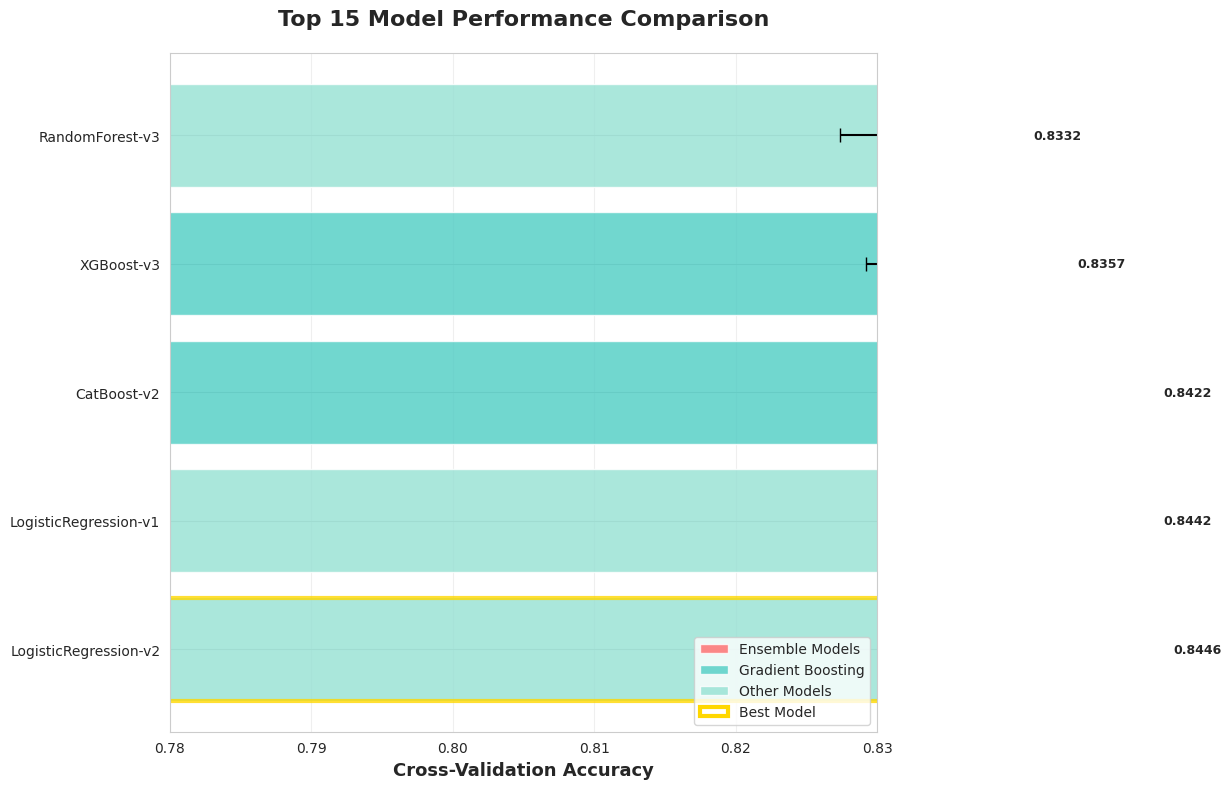

✓ Saved: 02_feature_importance.png


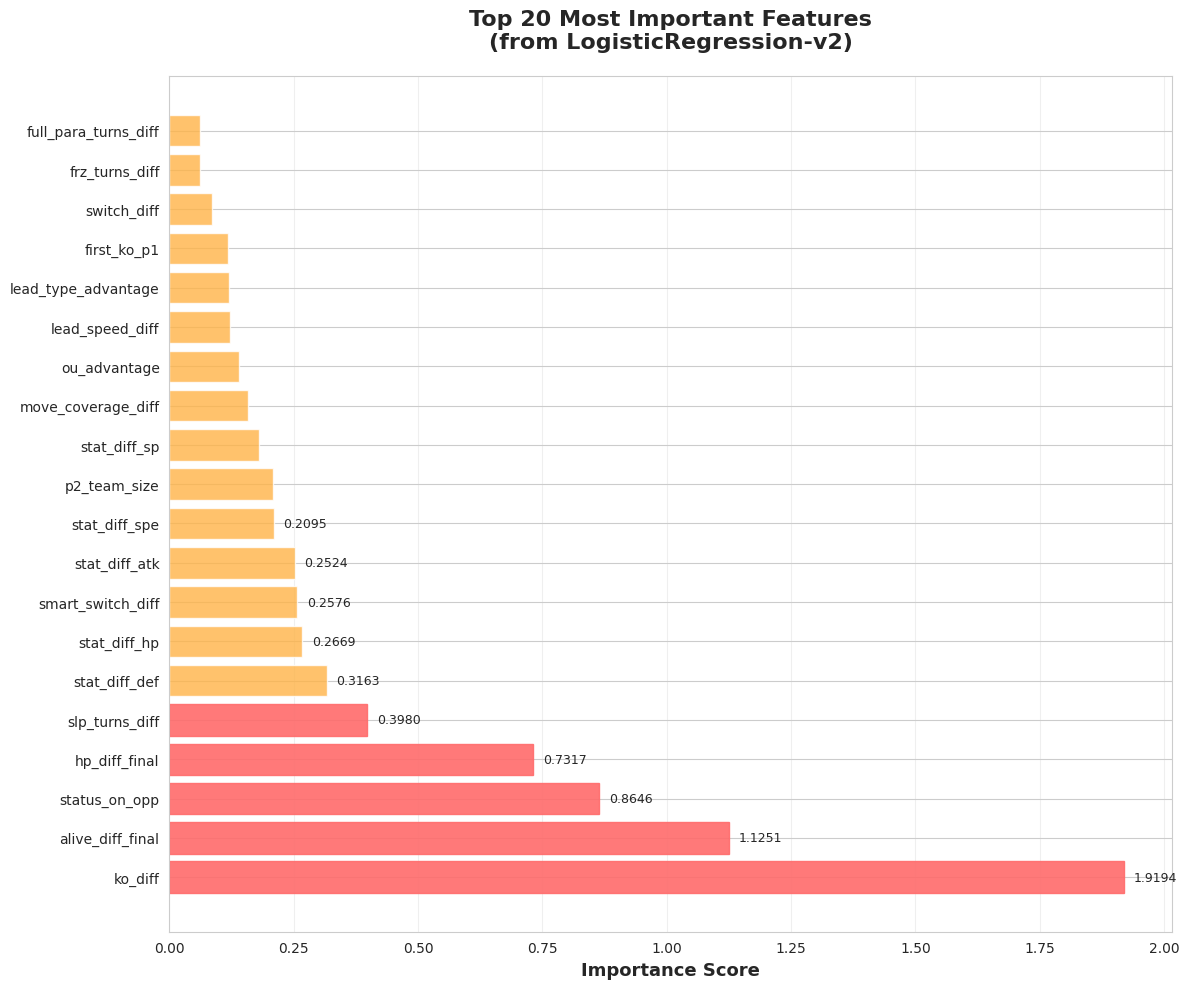

✓ Saved: 03_cv_score_distribution.png


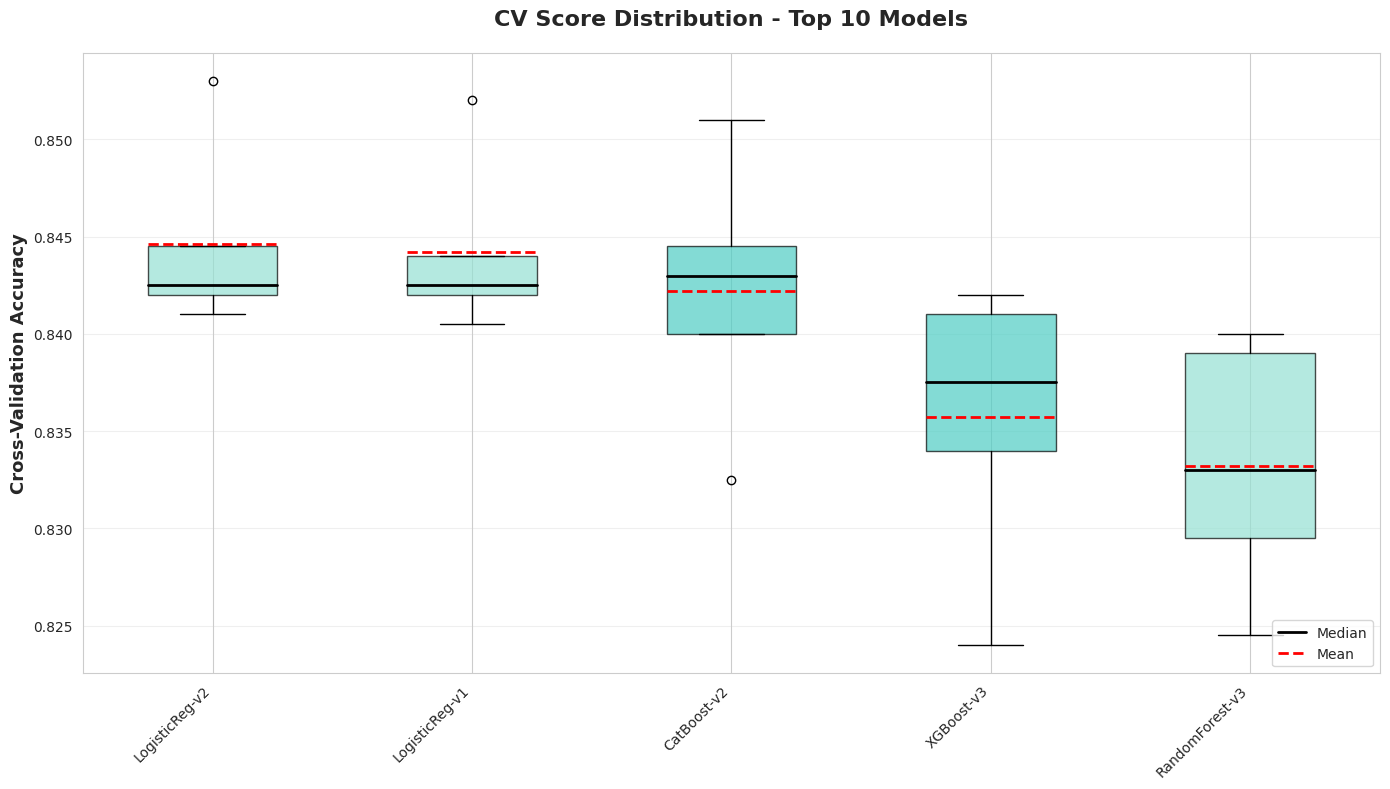

✓ Saved: 04_model_category_performance.png


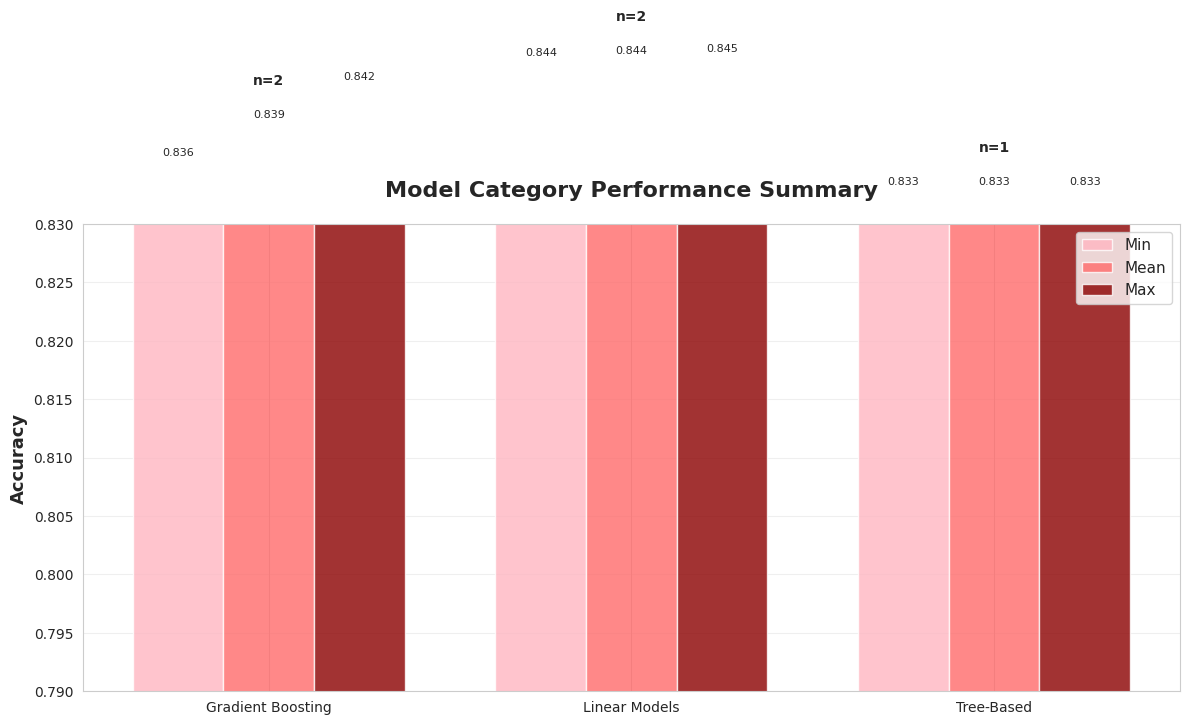

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


✓ Saved: 05_feature_correlation_heatmap.png


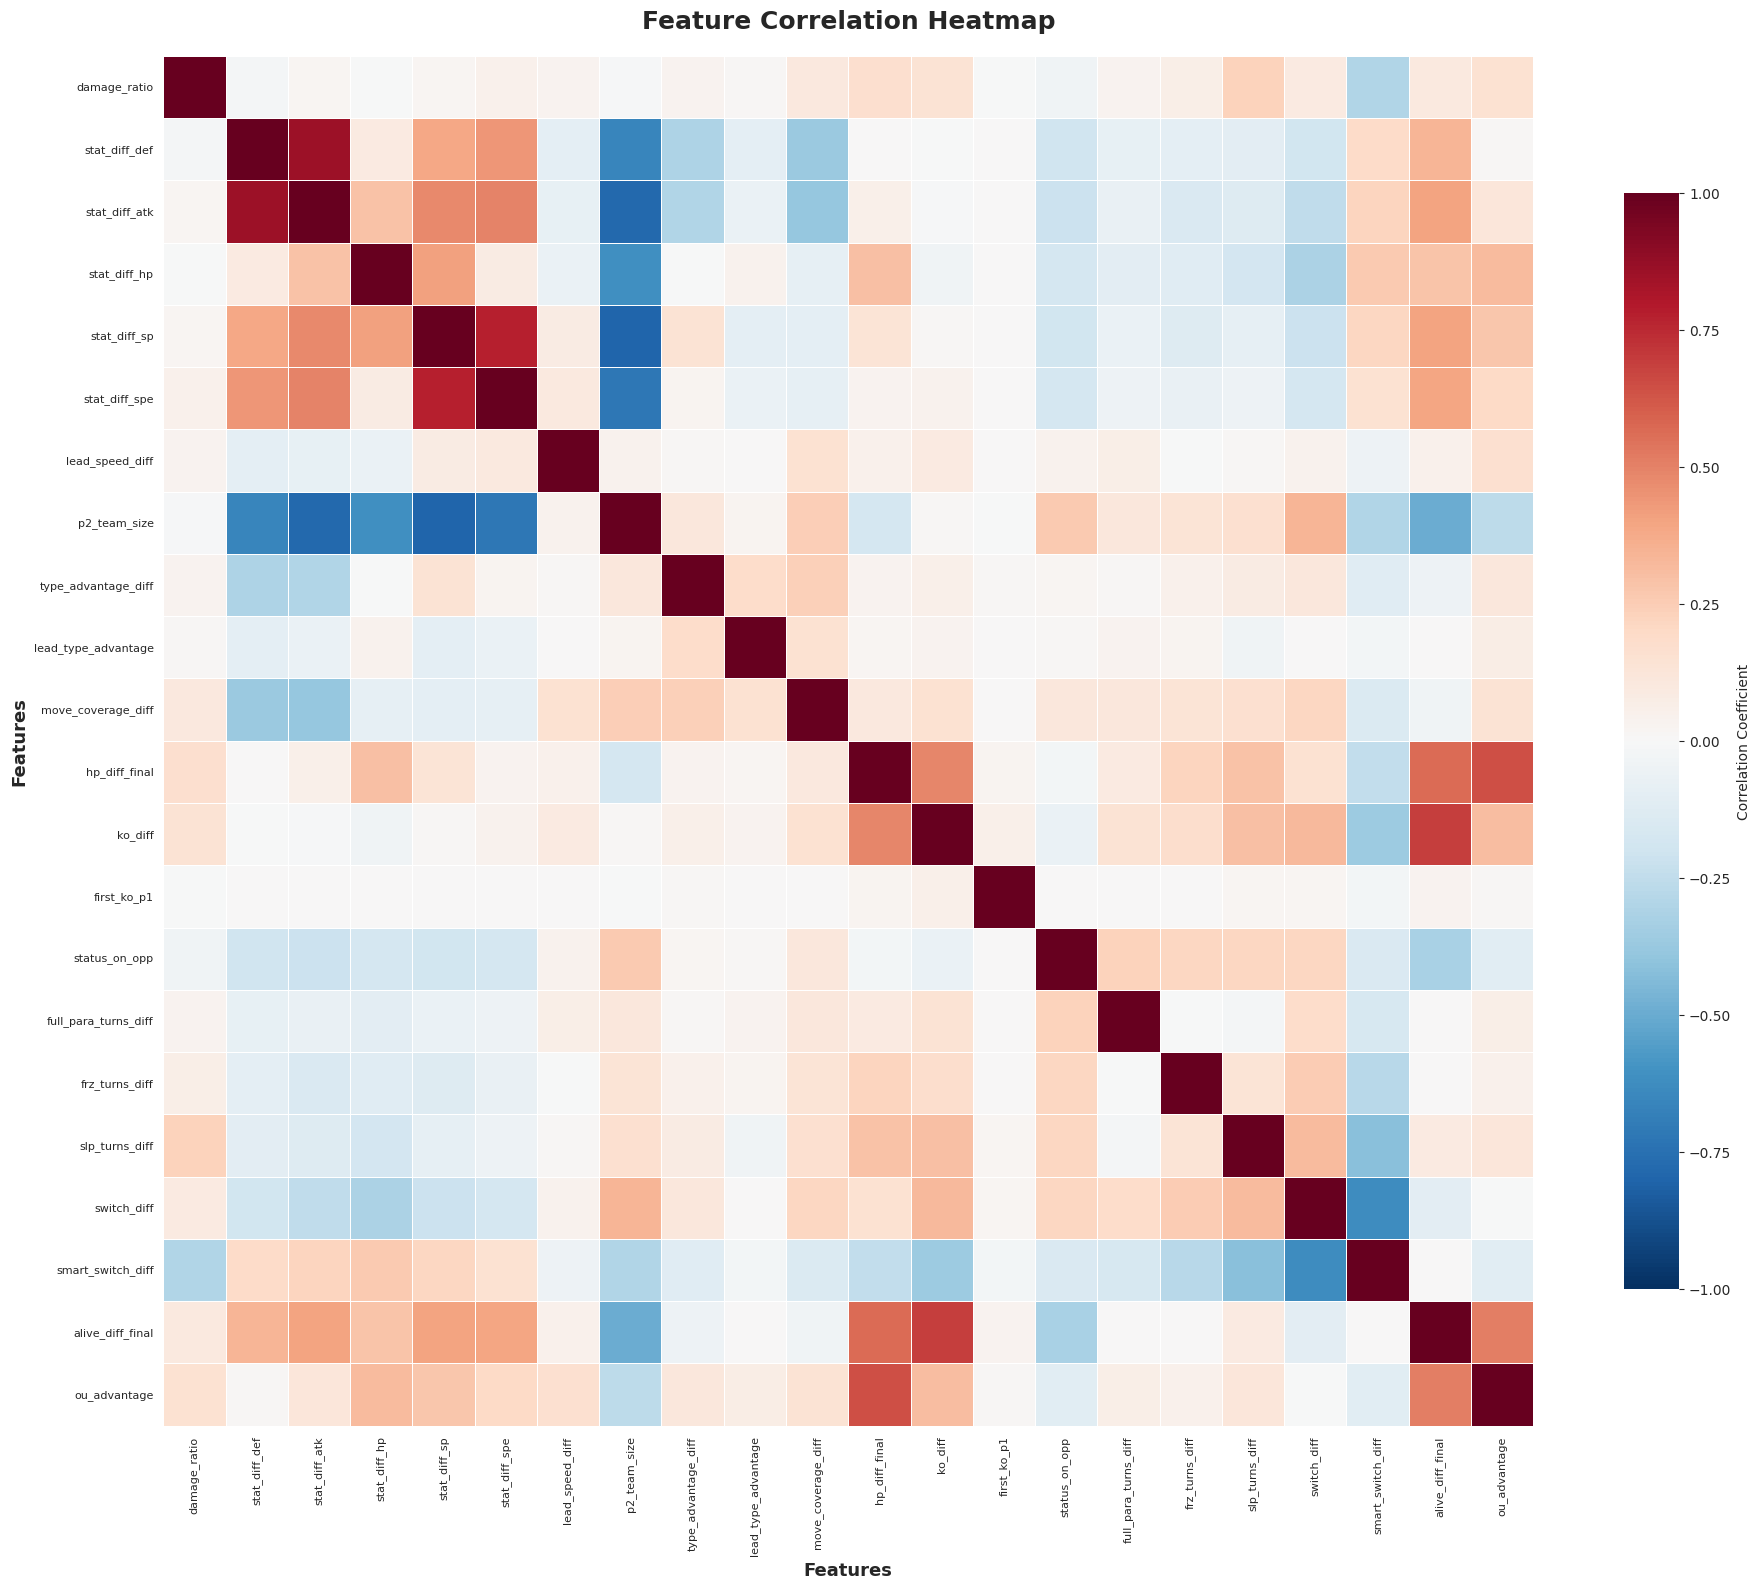


🔍 HIGHLY CORRELATED FEATURES (|correlation| > 0.8)

Found 1 highly correlated feature pairs:

  stat_diff_def                  <-> stat_diff_atk                   |  +0.8566

💡 Consider removing redundant features to reduce multicollinearity

📊 KEY INSIGHTS FROM VISUALIZATIONS

1. Best Model Performance:
   - LogisticRegression-v2: 0.8446 (+/- 0.0044)
   - Consistency: High

2. Features by Importance:

Rank   Feature                                  Importance  
------ ---------------------------------------- ------------
1      ko_diff                                  1.919448
2      alive_diff_final                         1.125066
3      status_on_opp                            0.864590
4      hp_diff_final                            0.731725
5      slp_turns_diff                           0.397970
6      stat_diff_def                            0.316260
7      stat_diff_hp                             0.266926
8      smart_switch_diff                        0.257573
9      stat_dif

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 10

# ============================================================
# PLOT 1: MODEL PERFORMANCE COMPARISON
# ============================================================

plt.figure(figsize=(14, 8))

# Prepare data
model_names = []
model_scores = []
model_stds = []
colors = []

for name, results in all_models_sorted[:15]:  # Top 15 models
    model_names.append(name)
    model_scores.append(results['cv_mean'])
    model_stds.append(results['cv_std'])
    
    # Color coding
    if 'Stacking' in name or 'Voting' in name:
        colors.append('#FF6B6B')  # Red for ensembles
    elif any(x in name for x in ['XGBoost', 'LightGBM', 'CatBoost']):
        colors.append('#4ECDC4')  # Teal for gradient boosting
    else:
        colors.append('#95E1D3')  # Light teal for others

# Create horizontal bar plot
y_pos = np.arange(len(model_names))
bars = plt.barh(y_pos, model_scores, xerr=model_stds, 
                color=colors, alpha=0.8, capsize=5)

# Highlight best model
best_idx = 0
bars[best_idx].set_edgecolor('gold')
bars[best_idx].set_linewidth(3)

plt.yticks(y_pos, model_names, fontsize=10)
plt.xlabel('Cross-Validation Accuracy', fontsize=13, fontweight='bold')
plt.title('Top 15 Model Performance Comparison', fontsize=16, fontweight='bold', pad=20)
plt.grid(axis='x', alpha=0.3)

# Add value labels
for i, (score, std) in enumerate(zip(model_scores, model_stds)):
    plt.text(score + std + 0.002, i, f'{score:.4f}', 
             va='center', fontsize=9, fontweight='bold')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#FF6B6B', alpha=0.8, label='Ensemble Models'),
    Patch(facecolor='#4ECDC4', alpha=0.8, label='Gradient Boosting'),
    Patch(facecolor='#95E1D3', alpha=0.8, label='Other Models'),
    Patch(facecolor='white', edgecolor='gold', linewidth=3, label='Best Model')
]
plt.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.xlim([0.78, 0.83])
plt.tight_layout()
plt.savefig('01_model_performance_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 01_model_performance_comparison.png")
plt.show()

# ============================================================
# PLOT 2: FEATURE IMPORTANCE (TOP 20)
# ============================================================

plt.figure(figsize=(12, 10))

# Extract feature importance from best model or best individual model
feature_importance_extracted = False

try:
    # Try to get feature importance from the best model
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        feature_importance_extracted = True
        model_used = best_model_name
    elif hasattr(best_model, 'named_steps') and hasattr(best_model.named_steps.get('classifier'), 'coef_'):
        importances = np.abs(best_model.named_steps['classifier'].coef_[0])
        feature_importance_extracted = True
        model_used = best_model_name
    else:
        # Fall back to best individual tree-based model
        for name, results in sorted_individual:
            model = results['model']
            if hasattr(model, 'feature_importances_'):
                # Train it first
                model.fit(X_train, y_train)
                importances = model.feature_importances_
                feature_importance_extracted = True
                model_used = name
                break
    
    if feature_importance_extracted and len(importances) == len(features):
        # Create FULL DataFrame with all features (don't truncate yet)
        feature_imp_df_full = pd.DataFrame({
            'feature': features,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        # Get top 20 for plotting
        feature_imp_df = feature_imp_df_full.head(20)
        
        # Plot
        y_pos = np.arange(len(feature_imp_df))
        bars = plt.barh(y_pos, feature_imp_df['importance'], color='#FFB347', alpha=0.8)
        
        # Highlight top 5
        for i in range(min(5, len(bars))):
            bars[i].set_color('#FF6B6B')
            bars[i].set_alpha(0.9)
        
        plt.yticks(y_pos, feature_imp_df['feature'], fontsize=10)
        plt.xlabel('Importance Score', fontsize=13, fontweight='bold')
        plt.title(f'Top 20 Most Important Features\n(from {model_used})', 
                 fontsize=16, fontweight='bold', pad=20)
        plt.grid(axis='x', alpha=0.3)
        
        # Add value labels for top 10
        for i, (idx, row) in enumerate(feature_imp_df.head(10).iterrows()):
            plt.text(row['importance'] + max(feature_imp_df['importance'])*0.01, i, 
                    f"{row['importance']:.4f}", va='center', fontsize=9)
        
        plt.tight_layout()
        plt.savefig('02_feature_importance.png', dpi=300, bbox_inches='tight')
        print("✓ Saved: 02_feature_importance.png")
        plt.show()
    else:
        raise Exception("Could not extract valid feature importance")
        
except Exception as e:
    # If feature importance fails, show a message
    plt.text(0.5, 0.5, 'Feature importance not available\nfor this model type', 
            ha='center', va='center', fontsize=14, style='italic',
            transform=plt.gca().transAxes)
    plt.title('Top 20 Most Important Features', fontsize=16, fontweight='bold', pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('02_feature_importance.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: 02_feature_importance.png (no data available)")
    plt.show()

# ============================================================
# PLOT 3: CV SCORE DISTRIBUTION (BOX PLOT)
# ============================================================

plt.figure(figsize=(14, 8))

# Select top 10 models for cleaner visualization
top_10_for_viz = all_models_sorted[:10]
box_data = []
box_labels = []
box_colors = []

for name, results in top_10_for_viz:
    box_data.append(results['cv_scores'])
    # Truncate long names
    short_name = name.replace('Ensemble', 'Ens').replace('Regression', 'Reg')
    if len(short_name) > 20:
        short_name = short_name[:17] + '...'
    box_labels.append(short_name)
    
    # Color based on type
    if 'Stacking' in name or 'Voting' in name:
        box_colors.append('#FF6B6B')
    elif any(x in name for x in ['XGBoost', 'LightGBM', 'CatBoost']):
        box_colors.append('#4ECDC4')
    else:
        box_colors.append('#95E1D3')

# Create box plot
bp = plt.boxplot(box_data, labels=box_labels, patch_artist=True,
                 showmeans=True, meanline=True,
                 medianprops=dict(color='black', linewidth=2),
                 meanprops=dict(color='red', linewidth=2, linestyle='--'))

# Color the boxes
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.ylabel('Cross-Validation Accuracy', fontsize=13, fontweight='bold')
plt.title('CV Score Distribution - Top 10 Models', fontsize=16, fontweight='bold', pad=20)
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')

# Add legend for mean/median
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='black', linewidth=2, label='Median'),
    Line2D([0], [0], color='red', linewidth=2, linestyle='--', label='Mean')
]
plt.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.savefig('03_cv_score_distribution.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 03_cv_score_distribution.png")
plt.show()

# ============================================================
# PLOT 4: MODEL CATEGORY PERFORMANCE
# ============================================================

plt.figure(figsize=(12, 8))

# Categorize models
categories = {
    'Ensemble Models': [],
    'Gradient Boosting': [],
    'Linear Models': [],
    'Tree-Based': [],
    'SVM': []
}

for name, results in model_results.items():
    score = results['cv_mean']
    
    if 'Stacking' in name or 'Voting' in name:
        categories['Ensemble Models'].append(score)
    elif any(x in name for x in ['XGBoost', 'LightGBM', 'CatBoost']):
        categories['Gradient Boosting'].append(score)
    elif 'Logistic' in name:
        categories['Linear Models'].append(score)
    elif 'RandomForest' in name or 'Forest' in name:
        categories['Tree-Based'].append(score)
    elif 'SVM' in name:
        categories['SVM'].append(score)

# Calculate statistics
category_names = []
category_means = []
category_maxs = []
category_mins = []
category_counts = []

for cat_name, scores in categories.items():
    if scores:  # Only include categories with models
        category_names.append(cat_name)
        category_means.append(np.mean(scores))
        category_maxs.append(np.max(scores))
        category_mins.append(np.min(scores))
        category_counts.append(len(scores))

x_pos = np.arange(len(category_names))

# Create grouped bar chart
width = 0.25
bars1 = plt.bar(x_pos - width, category_mins, width, label='Min', 
                color='#FFB6C1', alpha=0.8)
bars2 = plt.bar(x_pos, category_means, width, label='Mean', 
                color='#FF6B6B', alpha=0.8)
bars3 = plt.bar(x_pos + width, category_maxs, width, label='Max', 
                color='#8B0000', alpha=0.8)

plt.ylabel('Accuracy', fontsize=13, fontweight='bold')
plt.title('Model Category Performance Summary', fontsize=16, fontweight='bold', pad=20)
plt.xticks(x_pos, category_names)
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)

# Add count labels
for i, (count, mean) in enumerate(zip(category_counts, category_means)):
    plt.text(i, mean + 0.003, f'n={count}', ha='center', fontsize=10, 
            fontweight='bold')

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.ylim([0.79, 0.83])
plt.tight_layout()
plt.savefig('04_model_category_performance.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 04_model_category_performance.png")
plt.show()

# ============================================================
# PLOT 5: FEATURE CORRELATION HEATMAP
# ============================================================

plt.figure(figsize=(20, 16))

# First, filter out features with zero or near-zero variance to avoid NaN correlations
feature_variances = X_train[features].var()
valid_features = feature_variances[feature_variances > 1e-10].index.tolist()

if len(valid_features) < len(features):
    print(f"⚠️  Removed {len(features) - len(valid_features)} features with zero variance")
    removed_features = set(features) - set(valid_features)
    print(f"   Removed: {removed_features}")

correlation_matrix = X_train[valid_features].corr()

# Create heatmap
sns.heatmap(correlation_matrix, 
            cmap='RdBu_r',  # Red-Blue diverging colormap
            center=0,
            vmin=-1, 
            vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"},
            annot=False)  # Set to True if you want to see all values (will be crowded)

plt.title('Feature Correlation Heatmap', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Features', fontsize=13, fontweight='bold')
plt.ylabel('Features', fontsize=13, fontweight='bold')
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)

plt.tight_layout()
plt.savefig('05_feature_correlation_heatmap.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 05_feature_correlation_heatmap.png")
plt.show()

# Find highly correlated feature pairs (|correlation| > 0.8)
print("\n" + "="*70)
print("🔍 HIGHLY CORRELATED FEATURES (|correlation| > 0.8)")
print("="*70)

high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.8:
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                corr_value
            ))

if high_corr_pairs:
    # Sort by absolute correlation
    high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
    
    print(f"\nFound {len(high_corr_pairs)} highly correlated feature pairs:\n")
    for feat1, feat2, corr in high_corr_pairs[:20]:  # Show top 20
        print(f"  {feat1:30} <-> {feat2:30}  |  {corr:+.4f}")
    
    if len(high_corr_pairs) > 20:
        print(f"\n  ... and {len(high_corr_pairs) - 20} more pairs")
    
    print("\n💡 Consider removing redundant features to reduce multicollinearity")
else:
    print("\n✓ No highly correlated feature pairs found (good!)")

# ============================================================
# BONUS: PRINT KEY INSIGHTS
# ============================================================

print("\n" + "="*70)
print("📊 KEY INSIGHTS FROM VISUALIZATIONS")
print("="*70)

print(f"\n1. Best Model Performance:")
print(f"   - {best_model_name}: {best_results['cv_mean']:.4f} (+/- {best_results['cv_std']:.4f})")
print(f"   - Consistency: {'High' if best_results['cv_std'] < 0.006 else 'Moderate' if best_results['cv_std'] < 0.008 else 'Low'}")

if feature_importance_extracted:
    print(f"\n2. Features by Importance:")
    print(f"\n{'Rank':<6} {'Feature':<40} {'Importance':<12}")
    print(f"{'-'*6} {'-'*40} {'-'*12}")
    for i, (idx, row) in enumerate(feature_imp_df_full.iterrows(), 1):
        print(f"{i:<6} {row['feature']:<40} {row['importance']:.6f}")
    
    # Show worst 20 features (from the FULL dataframe with all features)
    print(f"\n   📉 Worst 20 Features (Lowest Importance):")
    print(f"\n{'Rank':<6} {'Feature':<40} {'Importance':<12}")
    print(f"{'-'*6} {'-'*40} {'-'*12}")
    # Get the bottom 20 features from the full dataframe
    worst_20 = feature_imp_df_full.tail(20).sort_values('importance', ascending=True)
    for i, (idx, row) in enumerate(worst_20.iterrows(), 1):
        print(f"{i:<6} {row['feature']:<40} {row['importance']:.6f}")

print(f"\n3. Model Category Rankings:")
for i, (cat, mean_score) in enumerate(zip(category_names, category_means), 1):
    print(f"   {i}. {cat}: {mean_score:.4f} avg")

best_fold = best_results['cv_scores'].argmax() + 1
worst_fold = best_results['cv_scores'].argmin() + 1
print(f"\n4. Cross-Validation Stability:")
print(f"   - Best fold: Fold {best_fold} ({best_results['cv_scores'].max():.4f})")
print(f"   - Worst fold: Fold {worst_fold} ({best_results['cv_scores'].min():.4f})")
print(f"   - Range: {best_results['cv_scores'].max() - best_results['cv_scores'].min():.4f}")

print(f"\n5. Feature Correlation:")
print(f"   - Total features: {len(features)}")
print(f"   - Highly correlated pairs: {len(high_corr_pairs)}")
if high_corr_pairs:
    print(f"   - Highest correlation: {max(high_corr_pairs, key=lambda x: abs(x[2]))[2]:+.4f}")

print(f"\n{'='*70}")
print("✅ All visualizations saved successfully!")
print("="*70)
print("\nGenerated files:")
print("  📊 01_model_performance_comparison.png")
print("  📊 02_feature_importance.png")
print("  📊 03_cv_score_distribution.png")
print("  📊 04_model_category_performance.png")
print("  📊 05_feature_correlation_heatmap.png")
print(f"\n{'='*70}\n")